##**Focus area for feedback**



In [4]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import itertools
flatten = itertools.chain.from_iterable

np.random.seed(3501)

In [5]:
class Customer:
  def __init__(self, t_arrival, t_served, service_duration):
    self.t_arrival = t_arrival
    self.t_served = t_served
    self.service_duration = service_duration
    self.t_leave = self.t_served + self.service_duration
    self.wait = self.t_served - self.t_arrival
    self.response = self.t_leave - self.t_arrival

class Manager:
  def __init__(self):
    self.occupied = False
    self.freed_when = 0
  def call(self,endtime):
    self.occupied = True
    self.freed_when = endtime
  def shoo(self):
    self.occupied = False

def find_shortestqueue(queues):
  #finds the shortest queue
  queuelengths = [len(i) for i in queues]
  index_shortest = queuelengths.index(min([len(q) for q in queues]))
  return index_shortest

def pick_highlight(queuelist):
  #just picks a queue that had the longest maximum queue length
  index_highlight = next(i for i, v in enumerate(queuelist) if max(list(flatten(queuelist))) in v)
  return index_highlight

def QSimulator(lmd=False, mu=False, sd = False, t_final=False, n_queues = False):
  if not lmd:
    lmd = float(input("Customer arrival rate λ: "))
    while not isinstance(lmd, float):
      print("Invalid input: please enter a float number.")
      lmd = float(input("Arrival rate λ: "))
  if not mu:
    mu = float(input("Service rate μ: "))
    while not isinstance(mu, float):
      print("Invalid input: please enter a float number.")
      mu = float(input("Service rate μ: "))
  if not sd:
    sd = float(input("Service duration standard deviation σ: "))
    while not isinstance(sd, float):
      print("Invalid input: please enter a float number.")
      sd = float(input("Service duration standard deviation σ: "))
  if not t_final:
    t_final = int(input("Simulation duration T (in discrete minutes): "))
    while not isinstance(t_final, int):
      print("Invalid input: please enter an integer.")
      t_final = int(input("Simulation duration T (in discrete minutes): "))
  if not n_queues:
    n_queues = int(input("Number of queues/servers n: "))
    while not isinstance(n_queues, int):
      print("Invalid input: please enter an integer.")
      n_queues = int(input("Number of queues/servers n: "))

  #initialize
  t = 0
  queues = [[] for i in range(n_queues)]
  mngr = Manager()

  ##### run simulation #####
  #print(f"Simulating {n_queues} server/queue(s)...\n")
  while t < t_final:
    queue_no = find_shortestqueue(queues)
    t_arrival = t + sts.expon.rvs(scale=1/lmd)

    if t_arrival > t_final:
      break #prevent customers entering after store closes

    if (mngr.freed_when <= t) and mngr.occupied:
      #print("mngr shooed")
      mngr.shoo()

    #service duration depending whether customer needs manager
    if sts.uniform.rvs() < 0.05: 
      service_duration = sts.norm.rvs(loc=4, scale=1)

      if not mngr.occupied:
        #print("mngr called immediately thus no adjustments")
        mngr.call(t + service_duration)
      else:
        #print("mngr called but deferred")
        mngr.call(mngr.freed_when + service_duration)

    else:
      service_duration = sts.norm.rvs(loc=mu, scale=sd)
    
    #print(f"manager available: {not mngr.occupied}") 

    # is a server available
    if len(queues[queue_no]) == 0:
      t_served = t_arrival
    else:
      t_served = max(t_arrival, queues[queue_no][-1].t_leave)
     
    queues[queue_no].append(Customer(t_arrival, t_served, service_duration))

    t = t_arrival
  ##### end simulation #####

  ##### analyze data #####
  waits = [c.wait for c in list(flatten(queues))]
  mean_wait = np.mean(waits)

  responses = [c.wait+c.service_duration for c in list(flatten(queues))]
  mean_response = np.mean(responses)

  service_durations = [c.service_duration for c in list(flatten(queues))]
  mean_service_duration = np.mean(service_durations)

  arrivals = []
  departures = []
  for i in range(n_queues): 
    arrivals.append([c.t_arrival for c in queues[i]])
    departures.append([c.t_served for c in queues[i]])


  qlen_cumulative = [[] for i in range(n_queues)]
  timestamps = [[] for i in range(n_queues)]
  for q in range(n_queues): #for every queue
    qlen_current = 0
    index = 0
    while len(departures[q]) > 0: #keep track of queue lengths
      if len(arrivals[q]) == 0:
        qlen_current -= 1
        t = departures[q].pop(0)
      
      elif arrivals[q][0] < departures[q][0]:
        qlen_current += 1
        t = arrivals[q].pop(0)

      elif arrivals[q][0] == departures[q][0]:
        arrivals[q].pop(0)
        t = departures[q].pop(0)

      else:
        qlen_current -= 1
        departures[q].pop(0)
      
      timestamps[q].append(t)
      qlen_cumulative[q].append(qlen_current)


  highlight_queue = pick_highlight(qlen_cumulative)

  """
  print(f"RESULTS SUMMARY: \n")
  print(f"{len(list(flatten(queues)))} customers served")
  print(f"average service time: {round(mean_service_duration,2)} min")
  print(f"average wait time: {round(mean_wait,2)} min")
  print(f"average time spent in system: {round(mean_response,2)} min")
  print(f"last customer departure: t = {round(max([c.t_leave for c in list(flatten(queues))]),2)}")
  print(f"highlight queue({highlight_queue}) plot: \n")
  plt.plot(timestamps[highlight_queue], qlen_cumulative[highlight_queue], "k.")
  plt.show()

  print("\n retrieval indexes: \n")
  print("0 - total customers served")
  print("1 - mean service time")
  print("2 - mean wait time")
  print("3 - mean response time")
  print("4 - maximum queue length")
  print("5 - duration of extended operation after t_final")
  print("\n*************** END SIMULATION ROUND *************** \n")
  """

  return ([len(list(flatten(queues))), mean_service_duration, mean_wait,
          mean_response, max(qlen_cumulative[highlight_queue]),
          max([c.t_leave for c in list(flatten(queues))]) - t_final])





In [13]:
samples_per_iter = 100

waittimes_compare = []
qlens_compare = []
delay_compare = []
waiterror_compare = []
qlenserror_compare = []
delayerror_compare = []

for n_queues in range(1,11):

  mean_waittime = []
  max_qlen = []
  delayed_operation = []

  for s in range(samples_per_iter): #run multiple simulations for each setting

    temporary_sample = QSimulator(1,3,1,540,n_queues) #run simulation 

    mean_waittime.append(temporary_sample[2])
    max_qlen.append(temporary_sample[4])
    delayed_operation.append(temporary_sample[5])

  interval_mean_waittime = sts.norm.interval(
      0.95, loc=np.mean(mean_waittime), 
      scale=(np.std(mean_waittime)/np.sqrt(samples_per_iter)))
  interval_max_qlen = sts.norm.interval(
      0.95, loc=np.mean(max_qlen), 
      scale=(np.std(max_qlen)/np.sqrt(samples_per_iter)))
  interval_delayed_operation = sts.norm.interval(
      0.95, loc=np.mean(delayed_operation), 
      scale=(np.std(delayed_operation)/np.sqrt(samples_per_iter)))
  
  print(f"{n_queues} queues/servers:")
  print(f"Average customer wait time (±2σ): {np.around(interval_mean_waittime,1)}")
  print(f"Average maximum queue length (±2σ): {list(map(int, np.nan_to_num(interval_max_qlen)))}")
  print(f"Average duration of operation after close (±2σ): {np.around(interval_delayed_operation,1)} \n")

  waittimes_compare.append(np.mean(interval_mean_waittime))
  waiterror_compare.append(interval_mean_waittime[1]-np.mean(interval_mean_waittime))
  qlens_compare.append(np.mean(interval_max_qlen))
  qlenserror_compare.append(interval_max_qlen[1]-np.mean(interval_max_qlen))
  delay_compare.append(np.mean(interval_delayed_operation))
  delayerror_compare.append(interval_delayed_operation[1]-np.mean(interval_delayed_operation))

1 queues/servers:
Average customer wait time (±2σ): [545.4 560.5]
Average maximum queue length (±2σ): [358, 367]
Average duration of operation after close (±2σ): [1091.1 1120.3] 

2 queues/servers:
Average customer wait time (±2σ): [140.2 147.2]
Average maximum queue length (±2σ): [94, 99]
Average duration of operation after close (±2σ): [290.6 303.9] 

3 queues/servers:
Average customer wait time (±2σ): [12.9 15.6]
Average maximum queue length (±2σ): [12, 14]
Average duration of operation after close (±2σ): [28.1 35.3] 

4 queues/servers:
Average customer wait time (±2σ): [1.2 1.3]
Average maximum queue length (±2σ): [3, 3]
Average duration of operation after close (±2σ): [3.7 4.9] 

5 queues/servers:
Average customer wait time (±2σ): [0.3 0.4]
Average maximum queue length (±2σ): [1, 2]
Average duration of operation after close (±2σ): [2.3 2.8] 

6 queues/servers:
Average customer wait time (±2σ): [0.1 0.1]
Average maximum queue length (±2σ): [1, 1]
Average duration of operation after

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


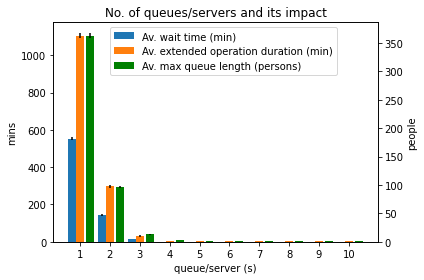

In [14]:
labels = [i for i in range(1,11)]

x = np.arange(0,len(labels)*3,3) 
width = 0.8

fig, ax1 = plt.subplots()

bar1 = ax1.bar(x - width, waittimes_compare, width, 
        label='Av. wait time (min)', 
        yerr = waiterror_compare)
bar2 = ax1.bar(x, delay_compare, width, 
        label='Av. extended operation duration (min)',
        yerr = delayerror_compare)

ax2 = ax1.twinx()

bar3 = ax2.bar(x + width+0.2, qlens_compare, width, color="green",
        label='Av. max queue length (persons)',
        yerr = qlenserror_compare)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('queue/server (s)')
ax1.set_ylabel('mins')
ax2.set_ylabel('people')
ax1.set_title('No. of queues/servers and its impact')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
fig.legend(loc = "best", bbox_to_anchor=(0.89,1), bbox_transform=ax1.transAxes)


fig.tight_layout()

plt.show()
